## 라이브러리 삽입



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product
import os

from xgboost import XGBRegressor
from xgboost import plot_importance

In [6]:
%%time

parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

directory="/home/aiffel/aiffel/sales"
test = pd.read_csv(directory+'/test.csv')
train = pd.read_csv(directory+'/sales_train.csv')
shops = pd.read_csv(directory+'/shops.csv')
items = pd.read_csv(directory+'/items.csv')
cats = pd.read_csv(directory+'/item_categories.csv')

CPU times: user 1.28 s, sys: 365 ms, total: 1.64 s
Wall time: 1.76 s


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
test_only = set(test['item_id'].unique()) - set(train['item_id'].unique())
print('test only items:', len(test_only))

test only items: 363


In [9]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


In [10]:
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('train:', train.shape)

train: (1224429, 6)


In [11]:
from itertools import product

# create all combinations
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')

# group by monthly
train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')
train_base['item_cnt_day'].fillna(0, inplace=True)
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])

In [12]:
train_base.head()

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
0,0,5,5037,NaN,NaN,0.0
1,0,5,5320,NaN,NaN,0.0
2,0,5,5233,NaN,NaN,0.0
3,0,5,5232,NaN,NaN,0.0
4,0,5,5268,NaN,NaN,0.0


## 이상치 제거

<AxesSubplot:xlabel='item_price'>

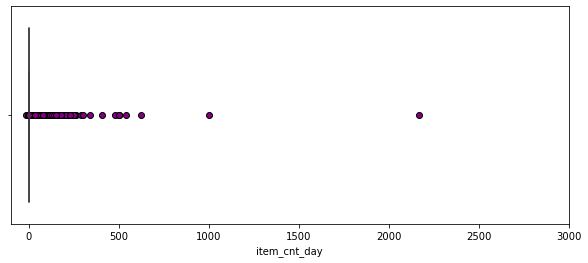

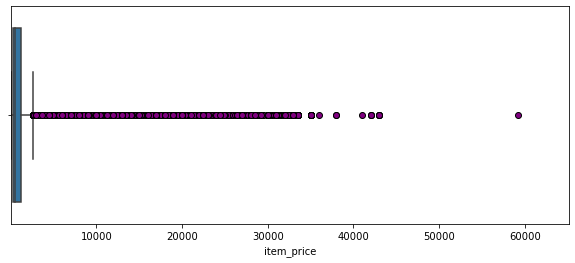

In [13]:
# 출처: Future Sales3
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [14]:
# 판매량과 가격의 이상치를 제거해 준다.
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

<AxesSubplot:xlabel='shop_id', ylabel='count'>

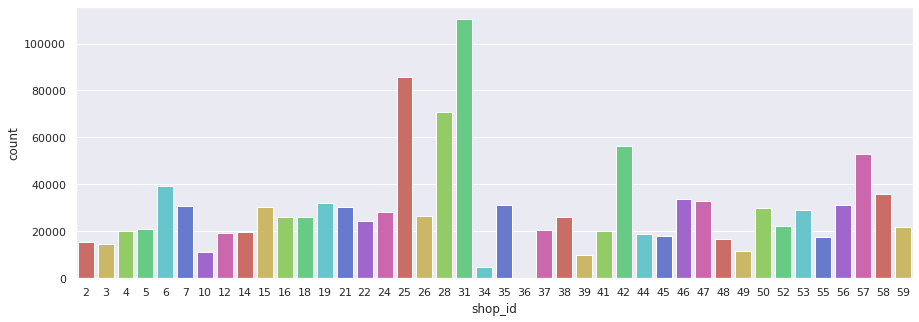

In [15]:
color = sns.color_palette("hls", 8)
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.countplot(x=train['shop_id'], data=train, palette=color)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


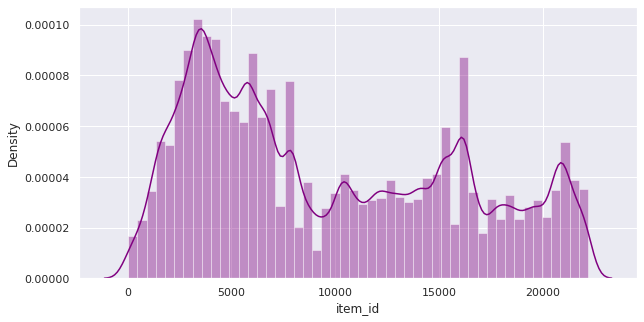

In [16]:
plt.figure(figsize=(10, 5))
sns.distplot(train['item_id'], color="purple");

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


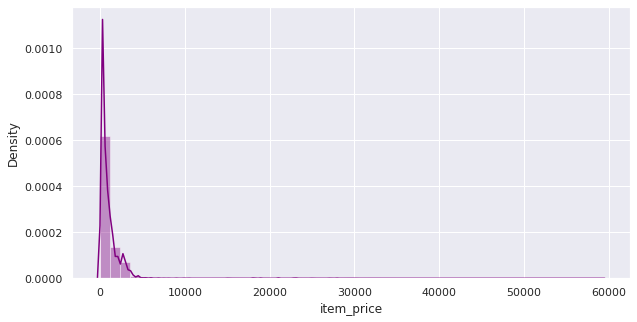

In [17]:
plt.figure(figsize=(10, 5))
sns.distplot(train['item_price'], color="purple");

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


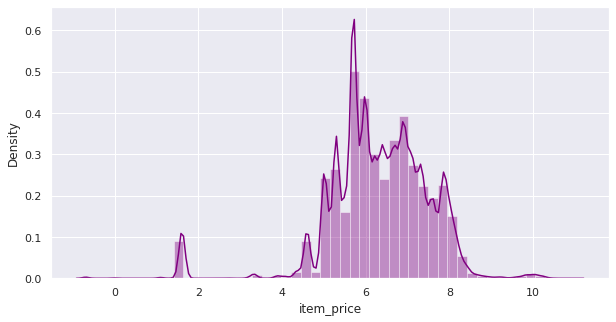

In [18]:
plt.figure(figsize=(10, 5))
sns.distplot(np.log(train['item_price']), color="purple");

## shop 데이터 정리

In [19]:
# shops 이름 정리
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [20]:
# shop city column 추가
from sklearn.preprocessing import LabelEncoder
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_name", "shop_id", "shop_city"]]

## item category 데이터 정리

In [21]:

cats["main_cat_id"] = cats.item_category_name.str.split("-").map( lambda x: x[0] )
cats["main_cat_id"] = LabelEncoder().fit_transform( cats.main_cat_id )
cats = cats[["item_category_name", "item_category_id", "main_cat_id"]]

In [22]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# РостовНаДону ТРК "Мегацентр Горизонт"
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [23]:
cats[0:20]

,item_category_name,item_category_id,main_cat_id
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
5,Аксессуары - PSVita,5,1
6,Аксессуары - XBOX 360,6,1
7,Аксессуары - XBOX ONE,7,1
8,Билеты (Цифра),8,2
9,Доставка товара,9,3


In [24]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [25]:
items = pd.merge(items, cats, on='item_category_id', how='left')

In [26]:
items=items.drop('item_category_name',axis=1)

In [27]:
items=items.drop('item_name',axis=1)

In [28]:
items

,item_id,item_category_id,main_cat_id
0,0,40,11
1,1,76,15
2,2,40,11
3,3,40,11
4,4,40,11
...,...,...,...
22165,22165,31,8
22166,22166,54,12
22167,22167,49,12
22168,22168,62,14


In [29]:
train=pd.merge(train,items, on ='item_id', how ='left')

In [30]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_cat_id
0,02.01.2013,0,59,22154,999.0,1.0,37,11
1,03.01.2013,0,25,2574,399.0,2.0,55,13
2,05.01.2013,0,25,2574,399.0,1.0,55,13
3,07.01.2013,0,25,2574,399.0,1.0,55,13
4,08.01.2013,0,25,2574,399.0,2.0,55,13
...,...,...,...,...,...,...,...,...
1224422,10.10.2015,33,25,7409,299.0,1.0,55,13
1224423,09.10.2015,33,25,7460,299.0,1.0,55,13
1224424,14.10.2015,33,25,7459,349.0,1.0,55,13
1224425,22.10.2015,33,25,7440,299.0,1.0,57,13


In [31]:
# https://www.kaggle.com/uladzimirkapeika/feature-engineering-lightgbm-top-1
# Feature engineering, LightGBM - Top 1%
train = train.groupby(['date_block_num','shop_id','item_id','item_category_id','main_cat_id']).agg({'item_cnt_day': ['sum']})
train.columns = ['item_cnt_month']
train.reset_index(inplace=True)

In [32]:
train

,date_block_num,shop_id,item_id,item_category_id,main_cat_id,item_cnt_month
0,0,2,33,37,11,1.0
1,0,2,482,73,15,1.0
2,0,2,491,73,15,1.0
3,0,2,839,73,15,1.0
4,0,2,1007,67,14,3.0
...,...,...,...,...,...,...
600153,33,59,22087,83,20,6.0
600154,33,59,22088,83,20,2.0
600155,33,59,22091,83,20,1.0
600156,33,59,22100,42,12,1.0


In [33]:
train['item_cnt_month'] = (train['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [34]:
train

,date_block_num,shop_id,item_id,item_category_id,main_cat_id,item_cnt_month
0,0,2,33,37,11,1.0
1,0,2,482,73,15,1.0
2,0,2,491,73,15,1.0
3,0,2,839,73,15,1.0
4,0,2,1007,67,14,3.0
...,...,...,...,...,...,...
600153,33,59,22087,83,20,6.0
600154,33,59,22088,83,20,2.0
600155,33,59,22091,83,20,1.0
600156,33,59,22100,42,12,1.0


In [35]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

5.567108392715454

In [36]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_month": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

1.342452049255371

In [37]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [38]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.02374553680419922

In [39]:
#https://www.kaggle.com/dlarionov/feature-engineering-xgboost
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [40]:
# https://www.kaggle.com/dlarionov/feature-engineering-xgboost
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


5.391055107116699

In [41]:
#https://www.kaggle.com/dlarionov/feature-engineering-xgboost
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


2.4221761226654053

In [42]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [43]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [44]:
data = matrix.copy()
del matrix
gc.collect()

60

In [45]:
data[data["date_block_num"]==34].shape

(214200, 10)

In [46]:
# https://www.kaggle.com/alexanderossipov/predict-future-sales-ensemble
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [47]:
# https://www.kaggle.com/dlarionov/feature-engineering-xgboost
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [48]:
del data
gc.collect();

In [49]:
# https://www.kaggle.com/snanilim/sales-preprocessing-and-prediction-by-xgboost
ts = time.time()

model = XGBRegressor(
    max_depth=20,
    n_estimators=500,
    min_child_weight=1, 
    colsample_bytree=0.8, 
    subsample=0.5, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.62406	validation_1-rmse:1.20873
[1]	validation_0-rmse:1.53034	validation_1-rmse:1.17210
[2]	validation_0-rmse:1.46727	validation_1-rmse:1.13974
[3]	validation_0-rmse:1.39281	validation_1-rmse:1.11307
[4]	validation_0-rmse:1.32566	validation_1-rmse:1.09238
[5]	validation_0-rmse:1.26541	validation_1-rmse:1.07542
[6]	validation_0-rmse:1.21545	validation_1-rmse:1.06169
[7]	validation_0-rmse:1.17185	validation_1-rmse:1.05317
[8]	validation_0-rmse:1.14023	validation_1-rmse:1.04238
[9]	validation_0-rmse:1.09918	validation_1-rmse:1.03541
[10]	validation_0-rmse:1.06580	validation_1-rmse:1.02979
[11]	validation_0-rmse:1.03404	validation_1-rmse:1.02503
[12]	validation_0-rmse:1.00760	validation_1-rmse:1.02268
[13]	validation_0-rmse:0.98122	validation_1-rmse:1.02038
[14]	validation_0-rmse:0.95577	validation_1-rmse:1.01877
[15]	validation_0-rmse:0.93437	validation_1-rmse:1.01921
[16]	validation_0-rmse:0.91422	validation_1-rmse:1.01883
[17]	validation_0-rmse:0.89611	validation

190.4725797176361

In [50]:
# https://www.kaggle.com/snanilim/sales-preprocessing-and-prediction-by-xgboost
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_hyp.csv', index=False)